# Convolutional Neural Network trained on MNIST in PyTorch

In this notebook, we aim to use a convolutional neural network to classify handwritten digits from 0-9 on 28x28 images in the MNIST dataset using PyTorch 1.12.1. There are 4 parts to this notebook:

-Preparing the dataset and other hyperparameters
-Creating the CNN
-Training the CNN
-Results

### Preparing the dataset and other hyperparameters

Before we prepare the dataset, we first create a new directory to store this run's checkpoints in, and we set a manual seed in order to have replicable results. We use the MNIST dataset provided in the <code>torchvision</code> library to access the MNIST dataset, we set the correct train parameter (True for the training set, False for the test set), and we set the transformations, using <code>ToTensor</code> in order to be processed and <code>Normalize</code> to allow gradient descent to perform more efficiently on a Gaussian distribution. We then create our dataloaders, which are used to efficiently load data using parallel computing and yields quicker results. We set up our dataset, our batch size (which we set to 64 as these are relatively small images), and shuffle to True in order to introduce more randomness. In order to follow the results of our model through various epochs, we will use subplots to measure training/validation loss and accuracy along every epoch. We finish by setting up the device (to use cuda if available to speed up the program) and hyperparameters such as learning rate and epochs.

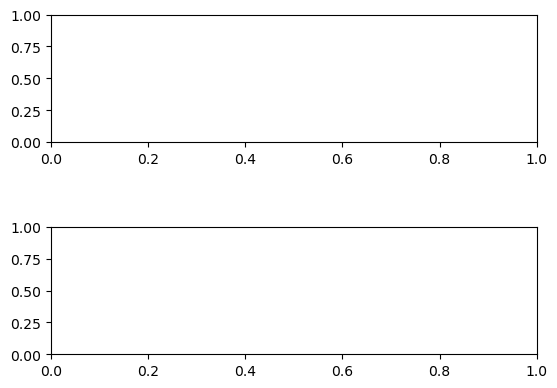

In [4]:
import os

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import datasets, transforms
from datetime import datetime
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

model_load = True
seed = 100
torch.manual_seed(seed)

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=4.0)

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3801,))]))
mnist_train, mnist_validation = train_test_split(mnist_train, test_size=0.25)

mnist_train = data.DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, num_workers=0)
mnist_validation = data.DataLoader(dataset=mnist_validation, batch_size=64, shuffle=True, num_workers=0)

mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3801,))]))
mnist_test = data.DataLoader(dataset=mnist_test, batch_size=64, shuffle=True, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-3
epochs = 10

### Creating the CNN

Now we can focus on our CNN architecture. Taking inspiration from the organized structure of VGG16/19, we will use a common kernel size. We will keep the same height and width between convolutions by using a stride and padding of 1, and we will half the height and width by using a kernel size of 2 in our pooling layers. We repeat the process of 2 convolutional layers and a max pooling layer twice, and finish with 3 fully connected layers. Weight initialization is already based on He-et-al initialization and does not need to be implemented separately. Although tuned to work better with LeakyReLU, there is insignificant performance differences when using ReLU instead. We then define functions that create folders that are named based on the time and date the program was run on in order to save checkpoints for that run in the folder, and other methods are made to load checkpoints given a relative directory. We also use <code>CrossEntropyLoss</code> as it's one of the better loss functions for classification problems, and we use Adam as it has adaptive learning rates, however as it does not change the learning rate much on its own, we also include a <code>CosineAnnealingLR</code> as it is popularly used in CV applications and gives time to the model to use a high learning rate for a couple of epochs before decreasing the LR. It is also favorable because the two hyperparameters are simple, with the number of epochs already known and simply setting the minimum LR to 0. We include a function to save checkpoints and load models in order to track and keep our progress in case something interrupts the training process. We decide to save per epoch, as each epoch takes a relatively long time to train locally. Finally, we include a function to measure accuracy for our final testing phase.

In [5]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # Starting with 1x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1, stride=1)  # 4x28x28
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1, stride=1)  # 8x28x28
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 8x14x14
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1)  # 16x14x14
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)  # 32x14x14
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 32x7x7
        self.fc1 = nn.Linear(in_features=32 * 7 * 7, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_current_time():
    now = datetime.now()
    now = now.strftime("%b-%d-%Y %H:%M:%S")
    return now

if not os.path.exists("runs"):
  os.mkdir("runs")

filename = "run " + get_current_time()
run_directory = "runs/" + filename
os.mkdir(run_directory)


def save_checkpoint(state, directory=run_directory):
    torch.save(state, directory + "/checkpoint " + get_current_time() + ".pt")
    print("saved checkpoint")


def get_accuracy(out, lbl):
    n = out.size(0)
    out = torch.softmax(out, dim=1)
    max_scores, max_idx_class = out.max(
        dim=1)
    return (max_idx_class == lbl).sum().item() / n


model = MNISTNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-8)


def load_model(path):
    load_dict = torch.load(path)
    model.load_state_dict(load_dict['model_state_dict'])
    optimizer.load_state_dict(load_dict['optimizer_state_dict'])


if model_load:
    load_model("runs/run Jul-04-2023 23:27:12/checkpoint Jul-05-2023 01:19:35.pt")
    model.train()

train_loss_array = []
train_accuracy_array = []
validation_loss_array = []
validation_accuracy_array = []
epoch_array = []
total_loss = 0

### Training the CNN

Now that we have created our model, we will focus on the training and validation loops. Let's first start with the training loop. We first use <code>optimizer.zero_grad()</code> in order to clear our gradients for an accurate parameter updates. Without this, the model will not train properly. We then take the output from the model and put it into the loss function we call <code>criterion()</code> in order to get the loss. We print it out and add it to our total loss gathered. We then use the <code>backward()</code> function to calculate the gradient in the backward pass, and we take a step with the optimizer. This happens 64 times due to our batch size, and after printing out some results for the training phase, we move on to validation. We do the same thing, however we do not perform a backward pass, nor do we take steps in the optimizer, as we do not wish to change the model during this phase. We save the checkpoint and repeat this however many times is specified by the <code>epochs</code> variable. We then prompt the user to select the best directory to put into testing.

In [6]:
for epoch in range(epochs):
    model.train()
    temp_accuracy_array = []
    for inputs, labels in mnist_train:
        optimizer.zero_grad()
        output = model(inputs)
        temp_accuracy_array.append(get_accuracy(output, labels))
        loss = criterion(output, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_accuracy_array.append(sum(temp_accuracy_array)/len(temp_accuracy_array))
    temp_accuracy_array = []

    print("Total Train loss on epoch " + str(epoch) + ": " + str(total_loss))
    train_loss_array.append(total_loss)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in mnist_validation:
            output = model(inputs)
            temp_accuracy_array.append(get_accuracy(output, labels))
            loss = criterion(output, labels)
            total_loss += loss.item()
    validation_accuracy_array.append(sum(temp_accuracy_array)/len(temp_accuracy_array))

    print("Total validation loss on epoch " + str(epoch) + ": " + str(total_loss))
    validation_loss_array.append(total_loss)
    total_loss = 0
    epoch_array.append(epoch)

    scheduler.step()

    checkpoint = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
                  'scheduler_state_dict': scheduler.state_dict()}
    save_checkpoint(checkpoint)

load_model(str(input("Directory for best epoch: ")))
model.eval()

Training - Epoch: 0 Loss: 0.0026618908159434795
Training - Epoch: 0 Loss: 0.008727557957172394
Training - Epoch: 0 Loss: 0.007648566272109747
Training - Epoch: 0 Loss: 0.0014483779668807983
Training - Epoch: 0 Loss: 0.022248005494475365
Training - Epoch: 0 Loss: 0.0016599394148215652
Training - Epoch: 0 Loss: 0.011963305063545704
Training - Epoch: 0 Loss: 0.002422294346615672
Training - Epoch: 0 Loss: 0.004159153904765844
Training - Epoch: 0 Loss: 0.0001549858134239912
Training - Epoch: 0 Loss: 0.00043410094804130495
Training - Epoch: 0 Loss: 0.00933658704161644
Training - Epoch: 0 Loss: 0.005613958463072777
Training - Epoch: 0 Loss: 0.001738066552206874
Training - Epoch: 0 Loss: 0.0016440398758277297
Training - Epoch: 0 Loss: 0.003450829302892089
Training - Epoch: 0 Loss: 0.000993796973489225
Training - Epoch: 0 Loss: 0.0013165655545890331
Training - Epoch: 0 Loss: 0.010290000587701797
Training - Epoch: 0 Loss: 0.005817316006869078
Training - Epoch: 0 Loss: 0.006770985666662455
Traini

KeyboardInterrupt: 

### Results

We finish by adding an array that keeps track of the accuracy during testing, and we print out the results and finally plot the losses and accuracies for training and validation.


In [ ]:
test_accuracy_array = []
with torch.no_grad():
    for inputs, labels in mnist_test:
        outputs = model(inputs)
        num_correct = 0
        test_accuracy_array.append(get_accuracy(outputs, labels))

print("Final accuracy: " + str(sum(test_accuracy_array) / len(test_accuracy_array)))

ax1.plot(epoch_array, train_loss_array, label='Training Loss', linestyle='dashed', color='red')
ax1.plot(epoch_array, validation_loss_array, label='Validation Loss', linestyle='dotted', color='blue')
ax1.legend()
ax1.set_title('Losses by Epoch')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses')

ax2.plot(epoch_array, train_accuracy_array, label='Training Accuracy', linestyle='dashed', color='red')
ax2.plot(epoch_array, validation_accuracy_array, label='Validation Accuracy', linestyle='dotted', color='blue')
ax2.legend()
ax2.set_title('Accuracy by Epoch')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.ylim(0, 1)

plt.show()